## D. Heslop, J. L. Scealy, A. T. A. Wood, L. Tauxe and A. P. Roberts (2023). A bootstrap common mean direction test. Journal of Geophysical Research.
### Example common mean direction test (see Section 3 of manuscript) performed on the data of Ao et al. (2013).

Please note that because this is a numerical procedure the results may differ slightly from those in the paper.

#### Import required libraries

In [1]:
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

-W- cartopy is not installed
    If you want to make maps, install using conda:
    conda install cartopy
-W- You haven't installed a module for plotting maps (cartopy or Basemap)
    Recommended: install cartopy.  With conda:
    conda install cartopy
    For more information, see http://earthref.org/PmagPy/Cookbook#getting_python


#### Function ```form_Mhat``` estimates $\hat{M}$ according to equation (4)

In [2]:
def form_Mhat(mhat):
    
    #input - mhat, estimated sample mean direction
    #output - Mhat matrix according to equation 4
    
    b = np.matrix(mhat[0:2][:,np.newaxis])
    c = mhat[2]
    
    if c==0:
        A1 = np.eye(2)-(b*b.getH())
    else:
        A1 = c/np.abs(c)*np.eye(2)-c/(np.abs(c)+np.abs(c)**2)*(b*b.getH())
        
    A2 = -b
    Mhat = np.hstack((A1,A2))
    return Mhat

#### Function ```form_Ghat``` estimates $\hat{G}$ according to equation (5)

In [3]:
def form_Ghat(X,Mhat):
    
    #input - X, collection of directions (one per column)
    #input - Mhat, Mhat matrix for mean direction
    #output - Ghat matrix according to equation 5

    n = np.shape(X)[1]
    term1 = np.power(np.linalg.norm(np.sum(X,axis=1)/n),-2)/n
    X = np.matrix(X)
    Mhat_T = Mhat.getT()
    Ghat = np.matrix(np.zeros((2,2)))
    
    for u in range(2):
        for v in range(2):
            for i in range(n):
                Ghat[u,v] += Mhat_T[:,u].getT()*X[:,i]*X[:,i].getT()*Mhat_T[:,v]
            Ghat[u,v] *= term1
    
    return Ghat

#### Function ```form_Q``` creates rotation matrix to rotation ```b``` to ```a``` according to equations (9) and (10)

In [4]:
def form_Q(a,b):
    
    #input - a, destination direction (unit vector)
    #input - b, starting direction (unit vector)
    #output - Q, rotation matrix so Qb = a
    
    a = np.matrix(a)
    a = np.reshape(a,(3,1))
    b = np.matrix(b)
    b = np.reshape(b,(3,1))

    c = b-a*(a.getT()*b)
    c /= np.linalg.norm(c)

    alpha = np.arccos(a.getT()*b)
    A = a*c.getT()-c*a.getT()

    Q = np.eye(3)+np.multiply(np.sin(alpha),A)+np.multiply(np.cos(alpha)-1,a*a.getT()+c*c.getT())
    
    return Q

#### Function ```find_CMDT_CR``` provides a collection of points on the boundary of the 1-$\alpha$ confidence region for the common mean direction according to the procedure in Appendix B.

N.b. ```find_CMDT_CR``` should only be used if null hypothesis of common mean direction cannot be rejected

In [5]:
def find_CMDT_CR(Ahat,Tc,mhat12):
    
    #Ahat - combined covariance matrix
    #input - Tc, T value on the boundary of the confidence region
    #input - mhat12, estimated common mean direction
    #output - mCI, sequence of points along confidence region
    
    [D,V] = np.linalg.eig(Ahat)
    
    idx=np.flip(np.argsort(D))
    D = D[idx]
    V = V[:,idx]
        
    mCI = np.zeros((3,201))
    y = np.matrix(np.zeros((3,1)))
    for i in range(201):
            theta = i*np.pi/100
            
            ylen = np.zeros(201);
            phi = np.linspace(0,np.pi/2,201)
            for j in range(201):
                y[0] = np.sin(phi[j])*np.cos(theta)*np.sqrt(Tc)/np.sqrt(D[0])
                y[1] = np.sin(phi[j])*np.sin(theta)*np.sqrt(Tc)/np.sqrt(D[1])
                y[2] = np.cos(phi[j])*np.sqrt(Tc)/np.sqrt(D[2])
                ylen[j] = np.linalg.norm(y)
                
            idx = np.argsort(ylen)
            phi0 = np.interp(1.0,ylen[idx],phi[idx]);
            y[0] = np.sin(phi0)*np.cos(theta)*np.sqrt(Tc)/np.sqrt(D[0])
            y[1] = np.sin(phi0)*np.sin(theta)*np.sqrt(Tc)/np.sqrt(D[1])
            y[2] = np.cos(phi0)*np.sqrt(Tc)/np.sqrt(D[2])
                
            mCI[:,i] = np.ndarray.flatten(V*y)
    
    #Check if points are in the correct hemisphere
    mCIbar = np.mean(mCI,axis=1)/np.linalg.norm(np.mean(mCI,axis=1))
    if np.arctan2(np.linalg.norm(np.cross(mhat12.T,mCIbar)),np.dot(mhat12.T,mCIbar))>np.pi/2:
        mCI *= -1
        
    return mCI

### Example processing
#### Import the example data sets and transform to Cartesian coordinates (1 direction per column). Estimate the mean direction via equation (3).

In [7]:
file = "Ao_normal.csv" #normal polarity directions from Ao et al. (2013)
F1 = pd.read_csv(file,header=None).to_numpy()
X1 = np.transpose(pmag.dir2cart(F1)) # normal directions in Cartesian coordinates (one direction per column)

file = "Ao_reversed.csv" #reversed polarity directions from Ao et al. (2013)
F2 = pd.read_csv(file,header=None).to_numpy()
X2 = -np.transpose(pmag.dir2cart(F2)) # inverted reversed directions in Cartesian coordinates

#### Estimate mean directions of data sets and pooled data set

In [8]:
n1 = np.shape(X1)[1] #number of observations in first data set
n2 = np.shape(X2)[1] #number of observations in second data set
n = n1 + n2 #total number of observations

X12 = np.hstack((X1,X2)) #form pooled data set

mhat1 = np.mean(X1,axis=1)
mhat1 /= np.linalg.norm(mhat1) #mean of first data set

mhat2 = np.mean(X2,axis=1)
mhat2 /= np.linalg.norm(mhat2) #mean of second data set

mhat12 = np.mean(X12,axis=1)
mhat12 /= np.linalg.norm(mhat12) #mean of pooled data set

#### Form $\hat{M}$ and $\hat{G}$ for each data set

In [9]:
Mhat1 = form_Mhat(mhat1) #Mhat of first data set
Ghat1 = form_Ghat(X1,Mhat1) #Ghat of first data set

Mhat2 = form_Mhat(mhat2) #Mhat of second data set
Ghat2 = form_Ghat(X2,Mhat2) #Ghat of second data set

#### Form $\hat{A}_0$ (equation 8) and find minimum eigenvalue ($\lambda_{\textrm{min}}$) and corresponding eigenvector ($\hat{m}_0$)

In [10]:
Ahat = Mhat1.getH()*np.linalg.inv(Ghat1)*Mhat1
Ahat += Mhat2.getH()*np.linalg.inv(Ghat2)*Mhat2
Ahat *= n

D,V = np.linalg.eig(Ahat)
idx = np.argmin(D)
Lmin = D[idx] #minimum eigenvalue
mhat0 = V[:,idx] #eigenvector corresponding to pooled sample mean

#### Transform data sets to estimated common mean direction $\hat{m}_0$

In [11]:
Q1 = form_Q(mhat0,mhat1) #rotation matrix for first data set
X10 = np.matmul(Q1,X1) #rotated version of first data set

Q2 = form_Q(mhat0,mhat2) #rotation matrix for second data set
X20 = np.matmul(Q2,X2) #rotated version of second data set

### Main bootstrap sequence

In [12]:
B = 10000 #number of bootstrap iterations
Lmin_b = np.zeros(B) #predefine output array for minimum eigenvalues
T_b = np.zeros(B) ##predefine output array for Tb (equation 11)

for i in range(B): #loop through boostrap iterations
    idx1 = np.random.randint(0,n1,n1) #select observation indicies with replacement
    X10_b = np.asarray(X10[:,idx1]) #form bootstrap sample from rotated version of first data set
    
    mhat10_b = np.mean(X10_b,axis=1) #mean direction of boostrap sample
    mhat10_b /= np.linalg.norm(mhat10_b)
    mhat10_b = (np.asarray(mhat10_b)).flatten()
    Mhat10_b = form_Mhat(mhat10_b) #\hat{M} for bootstrap sample
    Ghat10_b = form_Ghat(X10_b,Mhat10_b) #\hat{G} for bootstrap sample
    
    idx2 = np.random.randint(0,n2,n2) #select observation indicies with replacement
    X20_b = np.asarray(X20[:,idx2]) #form bootstrap sample from rotated version of second data set
    
    mhat20_b = np.mean(X20_b,axis=1) #mean direction of boostrap sample
    mhat20_b /= np.linalg.norm(mhat20_b)
    mhat20_b = (np.asarray(mhat20_b)).flatten()
    Mhat20_b = form_Mhat(mhat20_b) #\hat{M} for bootstrap sample
    Ghat20_b = form_Ghat(X20_b,Mhat20_b) #\hat{G} for bootstrap sample
    
    Ahat_b = Mhat10_b.getH()*np.linalg.inv(Ghat10_b)*Mhat10_b #bootstrap estimate of \hat{A}_0 (equation 8)
    Ahat_b += Mhat20_b.getH()*np.linalg.inv(Ghat20_b)*Mhat20_b
    Ahat_b *= n
    
    D_b,V_b = np.linalg.eig(Ahat_b) #Eigenvalues and eigenvectors
    Lmin_b[i] = np.min(D_b) #minimum eigenvalue for boostrap sample
    T_b[i] = np.matmul(np.matmul(np.transpose(mhat0),Ahat_b),mhat0) #Bootstrap T for pooled data (equation 11)

#### Main CMDT results

In [13]:
p = (1+np.sum(Lmin_b>=Lmin))/(B+1) # p-value (step 8 of CMDT, Section 3)
# (n.b., if p > 0.05 cannot reject null of common means at alpha = 0.05)

alpha = 0.05 #set significance level
Lmin_c = np.quantile(Lmin_b,1-alpha) #test critical value
# (n.b., if Lmin > Lmin_c reject null of common means at alpha significance level)

print("CMDT value = {:.2f}".format(Lmin))
print("CMDT critical value = {:.2f}".format(Lmin_c))
print("CMDT p-value = {:.2f}".format(p))

CMDT value = 8.22
CMDT critical value = 12.27
CMDT p-value = 0.14


#### Plot histogram of bootstrap values and compare to test statistic

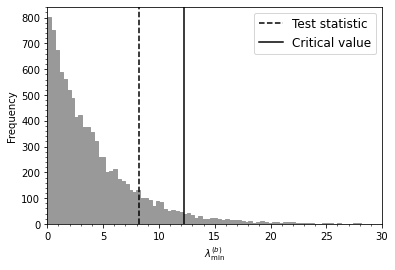

In [14]:
plt.figure()
plt.hist(Lmin_b,bins=int(np.sqrt(B)),color = "0.6", ec="0.6");
axes = plt.gca()
y_min, y_max = axes.get_ylim()
plt.plot([Lmin,Lmin],[y_min,y_max],'--k',label='Test statistic')
plt.plot([Lmin_c,Lmin_c],[y_min,y_max],'-k',label='Critical value')
plt.ylim([y_min,y_max])
x_min, x_max = axes.get_xlim()
plt.xlim([0,30])
plt.xlabel(r'$\lambda_{\rm{min}}^{(b)}$')
plt.ylabel('Frequency')
plt.minorticks_on()
plt.rcParams.update({'font.size': 12})
plt.legend();

## Test direction of interest (in this case GAD) against common mean of two groups

#### N.b. should only be calculated if null hypothesis of common mean direction cannot be rejected

In [15]:
T_c = np.quantile(T_b,1-alpha) #boundary value for confidence region on common mean direction
m = np.transpose(pmag.dir2cart((0.0,ipmag.inc_from_lat(40.15)))) #GAD direction in Cartesian coordinates
T_m = np.matmul(np.matmul(np.transpose(m),Ahat),m) #T-value for m-direction
print("95% confidence region threshold T = {:.2f}".format(T_c))
print("Tested direction T = {:.2f}".format(np.squeeze(np.asarray(T_m))))
#If T_m <= T_c then direction of interest is consistent with the common mean direction at alpha significance level

95% confidence region threshold T = 20.43
Tested direction T = 156.01


#### Plot histogram of bootstrap values and compare to test statistic (see Figure 6(a) in manuscript)

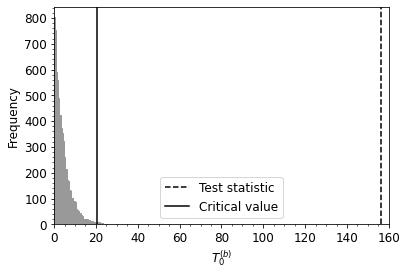

In [16]:
plt.figure()
plt.hist(Lmin_b,bins=int(np.sqrt(B)),color = "0.6", ec="0.6");
axes = plt.gca()
y_min, y_max = axes.get_ylim()
plt.plot(np.squeeze(np.asarray(T_m))*np.ones(2),[y_min,y_max],'--k',label='Test statistic')
plt.plot(T_c*np.ones(2),[y_min,y_max],'-k',label='Critical value')
plt.ylim([y_min,y_max])
x_min, x_max = axes.get_xlim()
plt.xlim([0,160])
plt.xlabel(r'$T_0^{(b)}$')
plt.ylabel('Frequency')
plt.minorticks_on()
plt.rcParams.update({'font.size': 12})
plt.legend();

#### Generate points along boundary of 95% confidence region and plot (see Figure 6(b) in manuscript)

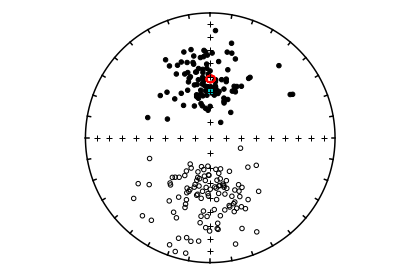

In [17]:
mCI = find_CMDT_CR(Ahat,T_c,mhat12) #generate 201 points along boundary
DIc = pmag.cart2dir(np.transpose(mCI)) #convert to dec and inc for plotting 
X1c = pmag.cart2dir(np.transpose(X1)) #convert to dec and inc for plotting
X2c = pmag.cart2dir(np.transpose(-X2)) #convert to dec and inc for plotting

ipmag.plot_net(1)
ipmag.plot_di(di_block=X1c,color='black',edge='black')
ipmag.plot_di(di_block=X2c,color='black',edge='black')
ipmag.plot_di(di_block=DIc,color='red',edge='red',marker='.',markersize=2)
ipmag.plot_di(dec = 0, inc = ipmag.inc_from_lat(40.15),marker='s',color='c')